<a href="https://colab.research.google.com/github/lauracarbaugh/lab_scraping/blob/main/DS-3001-Lab-1-Ehui-Carbaugh-Tao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
#df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(70, 6)


,title,price,year,link,brand,age
0,2016 chevy silverado 2500 4wd truck,18500,2016.0,https://charlottesville.craigslist.org/cto/d/s...,chevy,9.0
1,2013 subaru outback,7750,2013.0,https://charlottesville.craigslist.org/cto/d/c...,subaru,12.0
2,2014 audi a6,9500,2014.0,https://charlottesville.craigslist.org/cto/d/c...,audi,11.0
3,2019 chevy equinox ls,12500,2019.0,https://charlottesville.craigslist.org/cto/d/c...,chevy,6.0
4,2010 international 400 box truck,16500,2010.0,https://charlottesville.craigslist.org/cto/d/r...,missing,15.0


With the data in and wrangled, we can now do some analysis:

count       70.000000
mean     10919.971429
std      12479.495607
min       1000.000000
25%       3500.000000
50%       7200.000000
75%      13625.000000
max      79999.000000
Name: price, dtype: float64


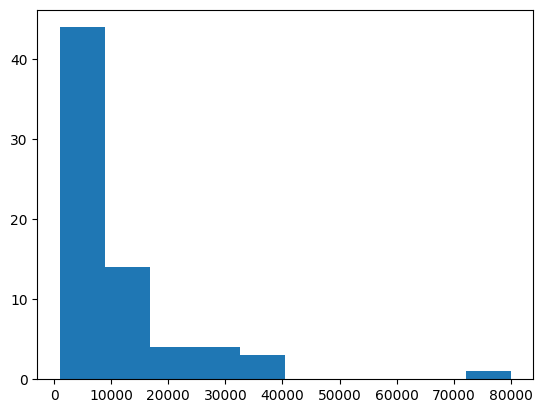

count    62.000000
mean     17.161290
std      12.679134
min       3.000000
25%      11.000000
50%      14.500000
75%      19.000000
max      70.000000
Name: age, dtype: float64


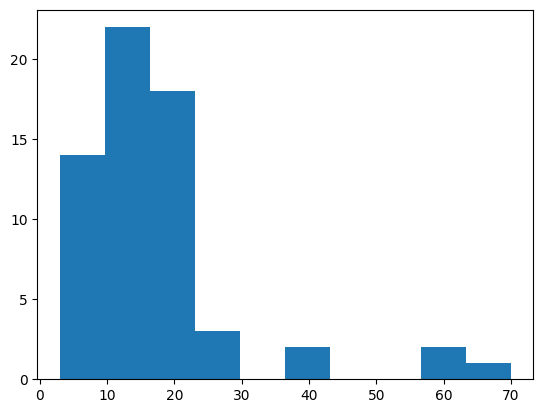

In [ ]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        1.0   3500.000000           NaN   3500.0   3500.0   3500.0   
audi         1.0   9500.000000           NaN   9500.0   9500.0   9500.0   
bmw          3.0  13743.333333   3029.460898  10500.0  12365.0  14230.0   
chevrolet    2.0  13500.000000  14142.135624   3500.0   8500.0  13500.0   
chevy        5.0  15499.800000   8269.295629   2999.0  12500.0  18500.0   
dodge        2.0  27000.000000  18384.776311  14000.0  20500.0  27000.0   
ford         6.0  12082.500000  12527.603023   1000.0   2100.0   7647.5   
honda        6.0   4391.666667   2017.031647   1000.0   3750.0   4700.0   
jeep         5.0   8990.000000   5182.952826   3250.0   5700.0   7500.0   
lexus        1.0   5000.000000           NaN   5000.0   5000.0   5000.0   
mazda        1.0   1000.000000           NaN   1000.0   1000.0   1000.0   
missing     23.0  11601.695652  17561.745273   1000.0   2800.0   5000.0   
porsche      1.0  23900.000000           NaN  23900.0  23900.0  23900.0   
subaru       3.0   5583.333333   3125.833222   2000.0   4500.0   7000.0   
toyota       8.0  10325.000000  10305.996867   3500.0   5900.0   7450.0   
volkswagen   1.0   7500.000000           NaN   7500.0   7500.0   7500.0   
volvo        1.0   4285.000000           NaN   4285.0   4285.0   4285.0   

                               
                 75%      max  
brand                          
acura        3500.00   3500.0  
audi         9500.00   9500.0  
bmw         15365.00  16500.0  
chevrolet   18500.00  23500.0  
chevy       18500.00  25000.0  
dodge       33500.00  40000.0  
ford        21373.75  30000.0  
honda        5350.00   6950.0  
jeep        12500.00  16000.0  
lexus        5000.00   5000.0  
mazda        1000.00   1000.0  
missing     10000.00  79999.0  
porsche     23900.00  23900.0  
subaru       7375.00   7750.0  
toyota       8225.00  35500.0  
volkswagen   7500.00   7500.0  
volvo        4285.00   4285.0

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                     
           count       mean        std   min   25%   50%    75%   max
brand                                                                
acura        1.0  18.000000        NaN  18.0  18.0  18.0  18.00  18.0
audi         1.0  11.000000        NaN  11.0  11.0  11.0  11.00  11.0
bmw          3.0  13.000000   6.928203   9.0   9.0   9.0  15.00  21.0
chevrolet    1.0  70.000000        NaN  70.0  70.0  70.0  70.00  70.0
chevy        5.0  16.200000  13.516656   6.0   9.0   9.0  18.00  39.0
dodge        2.0  10.000000   1.414214   9.0   9.5  10.0  10.50  11.0
ford         6.0  13.000000   8.763561   4.0   5.0  12.5  20.75  23.0
honda        6.0  17.000000   4.242641  12.0  13.5  17.0  20.50  22.0
jeep         5.0  22.600000  11.436783  11.0  17.0  19.0  25.00  41.0
lexus        1.0  17.000000        NaN  17.0  17.0  17.0  17.00  17.0
mazda        1.0  14.000000        NaN  14.0  14.0  14.0  14.00  14.0
missing     17.0  17.941176  16.199809   5.0  10.0  13.0  17.00  62.0
porsche      1.0  12.000000        NaN  12.0  12.0  12.0  12.00  12.0
subaru       3.0  16.666667   8.962886  11.0  11.5  12.0  19.50  27.0
toyota       7.0  14.000000   6.557439   3.0  12.0  15.0  15.50  25.0
volkswagen   1.0  17.000000        NaN  17.0  17.0  17.0  17.00  17.0
volvo        1.0  19.000000        NaN  19.0  19.0  19.0  19.00  19.0

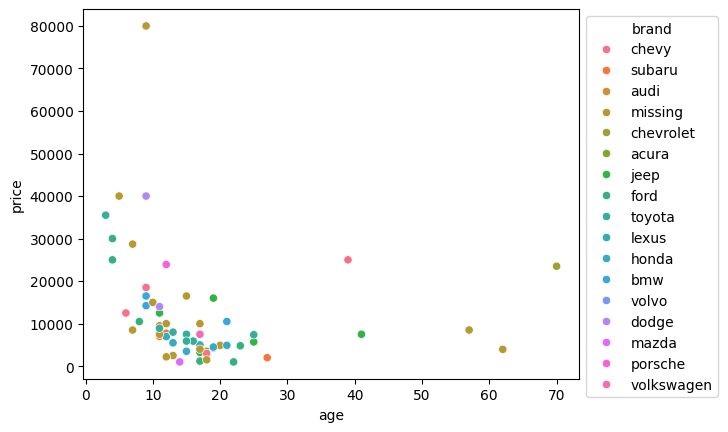

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.943179 -0.251469
log_age    -0.251469  0.364810
           log_price   log_age
log_price   1.000000 -0.433014
log_age    -0.433014  1.000000


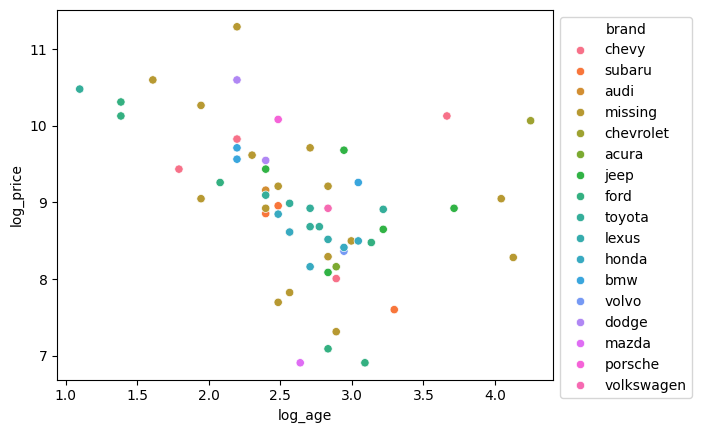

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

Atty Ehui, Simon Tao, Laura Carbaugh

Question 1:

We decided to look at furniture listings on Craigslist. We decided to gather the fields of item title, item price, furniture type, location, and URL for the listing. For EDA, we are going to look at count data for furniture types, the distribution for the price variable, and different groupings of furniture type, location, and price.

In [5]:
# Question 2:
import re

our_url = "https://charlottesville.craigslist.org/search/fua?purveyor=owner#search=2~gallery~52" # the page that we want to scrape from
get_raw = requests.get(our_url,headers=header) # pulling our page

our_bsObj = soup(get_raw.content,'html.parser') # parse html
our_listings = our_bsObj.find_all(class_="cl-static-search-result") # find all listings of the kind we want

types = ['chair', 'sofa', 'table', 'lamp', 'shelf', 'side table', 'rug', 'bookshelf', 'couch', 'desk', 'stool']
locations = ['charlottesville', 'palmyra', 'louisa', 'scottsville', 'orange', 'bremo bluff', 'gordonsville', 'crozet']

lab_data = []
for k in range( len(our_listings) ):
    # get the title of the listing
    item_title = our_listings[k].find('div',class_='title').get_text().lower()

    # price of the item that is listed
    item_price = our_listings[k].find('div',class_='price').get_text()

    # getting the link of each listing
    item_link = our_listings[k].find(href=True)['href']

    # get the town of where the listing is
    item_location_tag = our_listings[k].find('div',class_='location')
    if item_location_tag:
      item_location = item_location_tag.get_text().lower()
    else:
      item_location = 'unknown'

    # get type of furniture from the title string:
    matches = []
    for type in types:
      regex_pattern = rf'\b{type}s?\b'
      if re.search(regex_pattern, item_title):
        matches.append(type)

    if len(matches) == 0:
        furniture_type = 'other'
    else:
        furniture_type = matches[0]

    lab_data.append({'title':item_title,'price':item_price,'link':item_link,'location':item_location,'furniture_type':furniture_type})


In [6]:
# Question 3:
lab_df = pd.DataFrame(lab_data)
lab_df['price'] = lab_df['price'].str.replace('$','')
lab_df['price'] = lab_df['price'].str.replace(',','')
lab_df['price'] = pd.to_numeric(lab_df['price'],errors='coerce')
lab_df['location'] = lab_df['location'].str.replace('\n', '', regex=False)
lab_df

,title,price,link,location,furniture_type
0,wood spool magazine rack,15,https://charlottesville.craigslist.org/fuo/d/t...,unknown,other
1,vintage cedar chest,90,https://charlottesville.craigslist.org/fuo/d/t...,louisa ...,other
2,wall/floor small bench display books/doll etc,10,https://charlottesville.craigslist.org/fuo/d/t...,unknown,other
3,cherb gold color decorative frame,30,https://charlottesville.craigslist.org/fuo/d/t...,unknown,other
4,andres orpinas sign blue monochromics print,20,https://charlottesville.craigslist.org/fuo/d/t...,louisa ...,other
...,...,...,...,...,...
350,solid oak wine rack,28,https://charlottesville.craigslist.org/fuo/d/k...,scottsville ...,other
351,"heater - portable oil radiator heater, amazon ...",15,https://charlottesville.craigslist.org/fuo/d/c...,charlottesville ...,other
352,"bed mattress - full size, memory foam, 6 inch",9,https://charlottesville.craigslist.org/fuo/d/c...,charlottesville ...,other
353,"bed frame - full size, foldable, amazon basics",15,https://charlottesville.craigslist.org/fuo/d/c...,charlottesville ...,other


In [7]:
print("Shape:", lab_df.shape)
display(lab_df.describe())  # mean, std, quartiles for price
print("\nFurniture type counts:")
display(lab_df['furniture_type'].value_counts())

Shape: (355, 5)


,price
count,355.000000
mean,168.983099
std,393.627501
min,0.000000
25%,25.000000
50%,50.000000
75%,150.000000
max,3500.000000



Furniture type counts:


,count
furniture_type,
other,175
chair,60
table,48
lamp,20
desk,15
rug,14
sofa,7
stool,6
shelf,6


In [8]:
print("\nLocation counts (top 10):")
display(lab_df['location'].value_counts().head(10))


Location counts (top 10):


,count
location,
unknown,80
charlottesville,71
louisa,50
"palmyra, va",12
esmont,11
crozet,11
orange,11
lexington,11
palmyra,10


In [9]:
# Price by type
lab_df.loc[:,['price','furniture_type']].groupby('furniture_type').describe()

price                                                       \
                count        mean         std    min    25%    50%     75%   
furniture_type                                                               
bookshelf         3.0  118.333333  117.295922   25.0   52.5   80.0  165.00   
chair            60.0  103.000000  145.293974    5.0   20.0   47.5  150.00   
couch             1.0  800.000000         NaN  800.0  800.0  800.0  800.00   
desk             15.0  137.666667  124.066035   20.0   27.5  100.0  200.00   
lamp             20.0   43.350000   50.624807    5.0   10.0   25.0   50.50   
other           175.0  205.325714  484.155091    0.0   25.0   50.0  162.50   
rug              14.0  159.285714   89.654404   50.0  100.0  165.0  200.00   
shelf             6.0  107.500000  192.581152   20.0   25.0   25.0   43.75   
sofa              7.0  445.714286  671.195628   25.0   72.5  100.0  525.00   
stool             6.0   51.666667   59.048003   10.0   15.0   17.5   80.00   
table            48.0  155.937500  403.072794   10.0   30.0   75.0  128.75   

                        
                   max  
furniture_type          
bookshelf        250.0  
chair            900.0  
couch            800.0  
desk             400.0  
lamp             200.0  
other           3500.0  
rug              350.0  
shelf            500.0  
sofa            1800.0  
stool            150.0  
table           2800.0

In [10]:
# Price by location
lab_df.loc[:,['price','location']].groupby('location').describe()

price               \
                                                   count         mean   
location                                                                
                        afton, virginia        ...   1.0  1995.000000   
                        afton,va               ...   1.0    30.000000   
                        batesville             ...   4.0   960.000000   
                        belmont                ...   1.0   450.000000   
                        bremo bluff            ...   6.0   111.333333   
                        buckingham             ...   1.0   800.000000   
                        carrsbrook - 29n       ...   1.0    40.000000   
                        charlottescille        ...   4.0   213.250000   
                        charlottesville        ...  71.0   172.859155   
                        charlottesville (near t...   1.0   100.000000   
                        charlottesville (near u...   1.0    90.000000   
                        charlottesville,va     ...   1.0   125.000000   
                        charlottesville/crozet ...   1.0    20.000000   
                        crozet                      11.0   288.636364   
                        crozet (across from wes...   3.0    95.000000   
                        downtown charlottesvill...   1.0   129.000000   
                        dyke, va               ...   2.0    25.000000   
                        earlysville            ...   2.0   162.500000   
                        esmont                      11.0    66.818182   
                        florida                ...   1.0  2999.000000   
                        forest lakes           ...   1.0    75.000000   
                        goochland              ...   1.0    40.000000   
                        gordonsville           ...   3.0    78.333333   
                        gordonsville, va.      ...   3.0   998.333333   
                        hollymead              ...   4.0   131.250000   
                        lexington              ...  11.0   161.818182   
                        louisa                      50.0    53.960000   
                        lovingston             ...   1.0    15.000000   
                        madison                ...   1.0   150.000000   
                        orange                      11.0   495.454545   
                        palmyra                ...  10.0   308.900000   
                        palmyra,  va           ...   8.0   154.750000   
                        palmyra, va            ...  12.0   105.083333   
                        palmyra, va 22963      ...   1.0   315.000000   
                        pantops                ...   3.0    83.333333   
                        polo grounds           ...   1.0   110.000000   
                        ruckersville           ...   1.0    50.000000   
                        scottsville            ...   3.0    60.666667   
                        scottsville,  va       ...   5.0    82.000000   
                        scottsville, va        ...   7.0    62.142857   
                        somerset               ...   1.0   800.000000   
                        stanardsville          ...   5.0   122.000000   
                        staunton               ...   1.0   300.000000   
                        stoney point           ...   5.0   105.000000   
                        troutville             ...   1.0   100.000000   
unknown                                             80.0    92.112500   

                                                                         \
                                                            std     min   
location                                                                  
                        afton, virginia        ...          NaN  1995.0   
                        afton,va               ...          NaN    30.0   
                        batesville             ...  1694.618935    40.0   
                       

In [11]:
# Furniture type by location
lab_df.loc[:, ['furniture_type', 'location']].groupby(['furniture_type']).describe()

location         \
                  count unique   
furniture_type                   
bookshelf             3      2   
chair                60     20   
couch                 1      1   
desk                 15      7   
lamp                 20      6   
other               175     34   
rug                  14      3   
shelf                 6      2   
sofa                  7      3   
stool                 6      5   
table                48     16   

                                                                        
                                                              top freq  
furniture_type                                                          
bookshelf                               crozet (across from we...    2  
chair                                                     unknown   12  
couch                                   buckingham            ...    1  
desk                                    charlottesville       ...    6  
lamp                                                      unknown    6  
other                                                     unknown   45  
rug                                     lexington             ...   11  
shelf                                                     unknown    3  
sofa                                    charlottesville       ...    4  
stool                                                     unknown    2  
table                                   louisa                ...   10

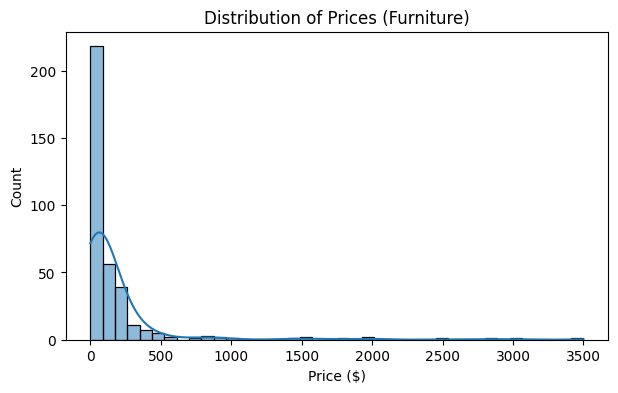

In [12]:
# Histogram of price
plt.figure(figsize=(7,4))
sns.histplot(lab_df['price'], bins=40, kde=True)
plt.xlabel('Price ($)')
plt.title('Distribution of Prices (Furniture)')
plt.show()

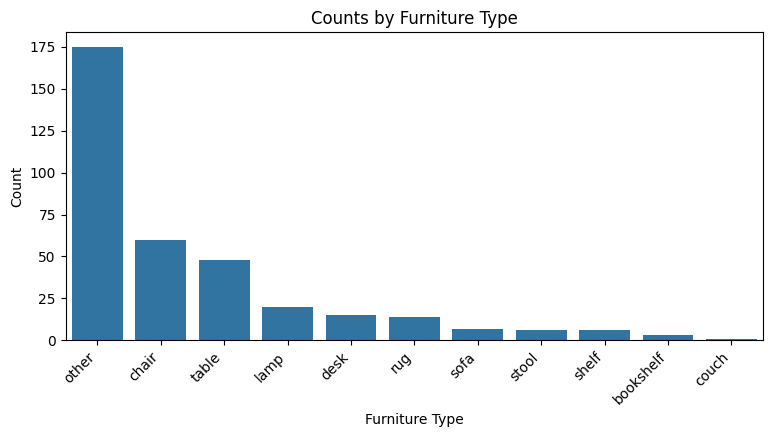

In [13]:
# Bar chart: counts by furniture type
plt.figure(figsize=(9,4))
sns.countplot(data=lab_df, x='furniture_type', order=lab_df['furniture_type'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Counts by Furniture Type')
plt.xlabel('Furniture Type')
plt.ylabel('Count')
plt.show()

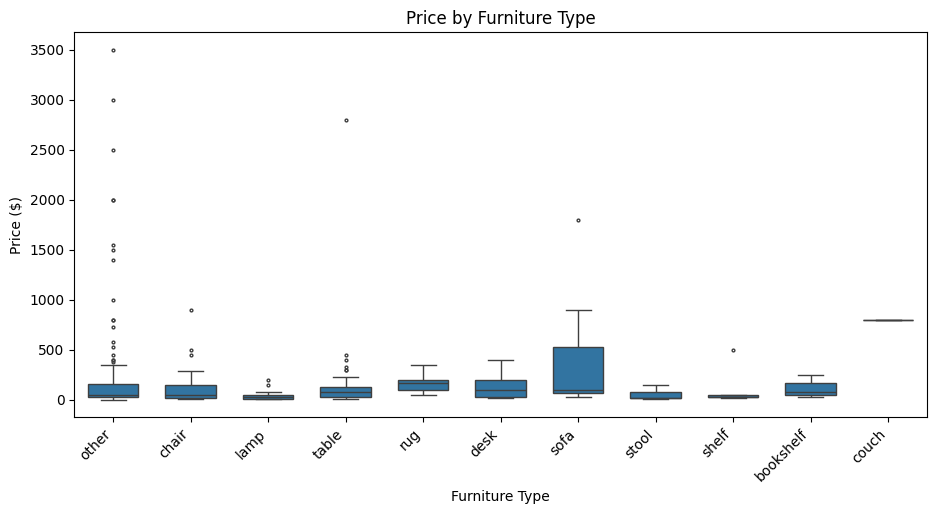

In [14]:
# Boxplot: price by furniture type
plt.figure(figsize=(11,5))
sns.boxplot(
    data=lab_df,
    x="furniture_type",
    y="price",
    width=0.65,
    fliersize=2)
plt.title("Price by Furniture Type")
plt.xlabel("Furniture Type")
plt.ylabel("Price ($)")
plt.xticks(rotation=45, ha='right')
plt.show()

Based on our exploratory data analysis, we found that most of the furniture on cragslist is classified as "other", and does not fall in one of the furniture types included. We went through and used the most common furniture types for classification and put everything else under the "other" category, so this likely led to a number of items falling in this braod category. "Other" furniture has the most entries with 174, and chair has the second highest number of entries at 60. Based on the boxplot, "other" furniture had the most outliers and spread. Sofa also had a rather large spread. The furniture type with the least amount of entries was couch at just 1 post. Excluding the couch, the highest average price was $445.71 for sofas.



Charlottesville had the most number of listings with 71 posts and a mean price of $172.86. Four of the listings misspelled Charlottesville as "Charlottescille." Some listings use "Charlottesville near the uva corner" or use "downtown Charlottesville" as the location of the post.